This notebook demonstrates the basic tools of the package with a publically available 10X human dataset.  We will first create a TCRDist matrix and then try to use this information to find cells most likely to be MAIT cells.

In [1]:
import pegasus as pg
import scanpy as sc
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import fast_tcrdist as ftcr
from collections import Counter

We should now have an .h5sc with the gene expression and corresponding TCR data called "human_10X_data.h5sc".  We can load it in and see the TCR information in the .obs dataframe.  Any cells that do not have TCR information will have empty strings in the TCR-relevant columns.

In [2]:
adata = pg.read_input(os.path.join("data", "human_10x_data.h5sc"))
adata.obs

2020-08-02 14:19:00,298 - pegasus - INFO - Time spent on 'read_input' = 0.53s.


Channel           TRA_cdr3  \
human_10x_data-AAACCTGAGCGATAGC  human_10x_data                      
human_10x_data-AAACCTGAGCTAAACA  human_10x_data                      
human_10x_data-AAACCTGAGGGAGTAA  human_10x_data                      
human_10x_data-AAACCTGAGTCTTGCA  human_10x_data       CAQSDSNYQLIW   
human_10x_data-AAACCTGAGTTCGATC  human_10x_data                      
...                                         ...                ...   
human_10x_data-TTTGTCATCCACGTTC  human_10x_data                      
human_10x_data-TTTGTCATCGCGTAGC  human_10x_data                      
human_10x_data-TTTGTCATCTTAACCT  human_10x_data                      
human_10x_data-TTTGTCATCTTACCGC  human_10x_data                      
human_10x_data-TTTGTCATCTTGTTTG  human_10x_data  CAVNRNAGGTSYGKLTF   

                                                                       TRA_cdr3_nt  \
human_10x_data-AAACCTGAGCGATAGC                                                      
human_10x_data-AAACCTGAGCTAAACA                                                      
human_10x_data-AAACCTGAGGGAGTAA                                                      
human_10x_data-AAACCTGAGTCTTGCA               TGTGCCCAATCGGATAGCAACTATCAGTTAATCTGG   
human_10x_data-AAACCTGAGTTCGATC                                                      
...                                                                            ...   
human_10x_data-TTTGTCATCCACGTTC                                                      
human_10x_data-TTTGTCATCGCGTAGC                                                      
human_10x_data-TTTGTCATCTTAACCT                                                      
human_10x_data-TTTGTCATCTTACCGC                                                      
human_10x_data-TTTGTCATCTTGTTTG  TGTGCCGTGAACCGGAATGCTGGTGGTACTAGCTATGGAAAGCTGA...   

                                TRA_j_gene TRA_reads TRA_umis TRA_v_gene  \
human_10x_data-AAACCTGAGCGATAGC                                            
human_10x_data-AAACCTGAGCTAAACA                                            
human_10x_data-AAACCTGAGGGAGTAA                                            
human_10x_data-AAACCTGAGTCTTGCA     TRAJ33      4941        6    TRAV1-2   
human_10x_data-AAACCTGAGTTCGATC                                            
...                                    ...       ...      ...        ...   
human_10x_data-TTTGTCATCCACGTTC                                            
human_10x_data-TTTGTCATCGCGTAGC                                            
human_10x_data-TTTGTCATCTTAACCT                                            
human_10x_data-TTTGTCATCTTACCGC                                            
human_10x_data-TTTGTCATCTTGTTTG     TRAJ52       362        1   TRAV12-2   

                                         TRB_cdr3  \
human_10x_data-AAACCTGAGCGATAGC                     
human_10x_data-AAACCTGAGCTAAACA                     
human_10x_data-AAACCTGAGGGAGTAA                     
human_10x_data-AAACCTGAGTCTTGCA  CASSPTGGSGYNEQFF   
human_10x_data-AAACCTGAGTTCGATC                     
...                                           ...   
human_10x_data-TTTGTCATCCACGTTC                     
human_10x_data-TTTGTCATCGCGTAGC                     
human_10x_data-TTTGTCATCTTAACCT  CATSLETSGITGELFF   
human_10x_data-TTTGTCATCTTACCGC                     
human_10x_data-TTTGTCATCTTGTTTG   CASSVRVLGTNEQFF   

                                                                      TRB_cdr3_nt  \
human_10x_data-AAACCTGAGCGATAGC                                                     
human_10x_data-AAACCTGAGCTAAACA                                                     
human_10x_data-AAACCTGAGGGAGTAA                                                     
human_10x_data-AAACCTGAGTCTTGCA  TGTGCCAGCAGTCCGACAGGGGGTTCGGGTTACAATGAGCAGTTCTTC   
human_10x_data-AAACCTGAGTTCGATC                                                     
...                                                                           ...   
human_10x_data-TTTGTC

Next, we want to make a "TCRDist dataset" object from our anndata object.  This will take information from cells that have complete TCR information (TRA CDR3 and V gene, TRB CDR3 and V gene).  It will also automatically trim the CDR3s to the "likely anitgen-contact" residues that will be used for the TCRdist calculation.  All of this can be seen in the .obs part of the object

In [3]:
tcrdist_data = ftcr.tcrdist.create_datasets.tcrdist_dataset_from_anndata(adata, organism = "human")
tcrdist_data.obs

TRA_cdr3           TRB_cdr3  \
human_10x_data-AAACCTGAGTCTTGCA       CAQSDSNYQLIW   CASSPTGGSGYNEQFF   
human_10x_data-AAACCTGCACGGTGTC     CAGRYTGTASKLTF       CASSRDTYEQYF   
human_10x_data-AAACCTGCAGATGGGT         CAVLTNDMRF     CASSGDRGNYGYTF   
human_10x_data-AAACCTGTCCTTGCCA    CATDFNTGANSKLTF  CASTRLKFSGSTDTQYF   
human_10x_data-AAACGGGCAATCACAC      CAASNNAGNMLTF    CASSEFSYLPNEQFF   
...                                            ...                ...   
human_10x_data-TTTGTCAAGACCTAGG  CILRGSYSGAGSYQLTF   CASSLGRRGSGTEAFF   
human_10x_data-TTTGTCAAGGAATGGA       CAVMDSNYQLIW    CSAKTGQGEADTQYF   
human_10x_data-TTTGTCACAGGTGGAT         CGTGANNLFF      CASSVVPGYEQFF   
human_10x_data-TTTGTCAGTCCGAAGA       CIYNQAGTALIF    CASSLVATGVEKLFF   
human_10x_data-TTTGTCATCTTGTTTG  CAVNRNAGGTSYGKLTF    CASSVRVLGTNEQFF   

                                TRA_v_gene TRB_v_gene TRA_cdr3_trimmed  \
human_10x_data-AAACCTGAGTCTTGCA    TRAV1-2    TRBV6-4          SDSNYQL   
human_10x_data-AAACCTGCACGGTGTC     TRAV41    TRBV5-4        RYTGTASKL   
human_10x_data-AAACCTGCAGATGGGT     TRAV21    TRBV5-6            LTNDM   
human_10x_data-AAACCTGTCCTTGCCA     TRAV17     TRBV28       DFNTGANSKL   
human_10x_data-AAACGGGCAATCACAC  TRAV23DV6      TRBV2         SNNAGNML   
...                                    ...        ...              ...   
human_10x_data-TTTGTCAAGACCTAGG   TRAV26-2    TRBV7-3     RGSYSGAGSYQL   
human_10x_data-TTTGTCAAGGAATGGA    TRAV1-2   TRBV20-1          MDSNYQL   
human_10x_data-TTTGTCACAGGTGGAT    TRAV9-2      TRBV9            GANNL   
human_10x_data-TTTGTCAGTCCGAAGA   TRAV26-2   TRBV11-2          NQAGTAL   
human_10x_data-TTTGTCATCTTGTTTG   TRAV12-2      TRBV2     NRNAGGTSYGKL   

                                TRB_cdr3_trimmed  TRA_cdr3_length  \
human_10x_data-AAACCTGAGTCTTGCA      SPTGGSGYNEQ               12   
human_10x_data-AAACCTGCACGGTGTC          SRDTYEQ               14   
human_10x_data-AAACCTGCAGATGGGT        SGDRGNYGY               10   
human_10x_data-AAACCTGTCCTTGCCA     TRLKFSGSTDTQ               15   
human_10x_data-AAACGGGCAATCACAC       SEFSYLPNEQ               13   
...                                          ...              ...   
human_10x_data-TTTGTCAAGACCTAGG      SLGRRGSGTEA               17   
human_10x_data-TTTGTCAAGGAATGGA       KTGQGEADTQ               12   
human_10x_data-TTTGTCACAGGTGGAT         SVVPGYEQ               10   
human_10x_data-TTTGTCAGTCCGAAGA       SLVATGVEKL               12   
human_10x_data-TTTGTCATCTTGTTTG       SVRVLGTNEQ               17   

                                 TRB_cdr3_length  
human_10x_data-AAACCTGAGTCTTGCA               16  
human_10x_data-AAACCTGCACGGTGTC               12  
human_10x_data-AAACCTGCAGATGGGT               14  
human_10x_data-AAACCTGTCCTTGCCA               17  
human_10x_data-AAACGGGCAATCACAC               15  
...                                          ...  
human_10x_data-TTTGTCAAGACCTAGG               16  
human_10x_data-TTTGTCAAGGAATGGA               15  
human_10x_data-TTTGTCACAGGTGGAT               13  
human_10x_data-TTTGTCAGTCCGAAGA               15  
human_10x_data-TTTGTCATCTTGTTTG               15  

[2447 rows x 8 columns]

With all data in hand, we can now create a TCRDist distance matrix.  Using the create_tcrdist_matrix_nw() function will create the distance matrix with an optimized Needleman-Wunsch algorithm.

In [4]:
tcrdist_data.create_tcrdist_matrix_nw()

time for mtx: 90.10366630554199 seconds
[[  0 287 287 ... 256 279 298]
 [287   0 233 ... 211 249 234]
 [287 233   0 ... 208 289 313]
 ...
 [256 211 208 ...   0 240 266]
 [279 249 289 ... 240   0 270]
 [298 234 313 ... 266 270   0]]


Now we can plot the distance matrix to look for structure within the TCRs

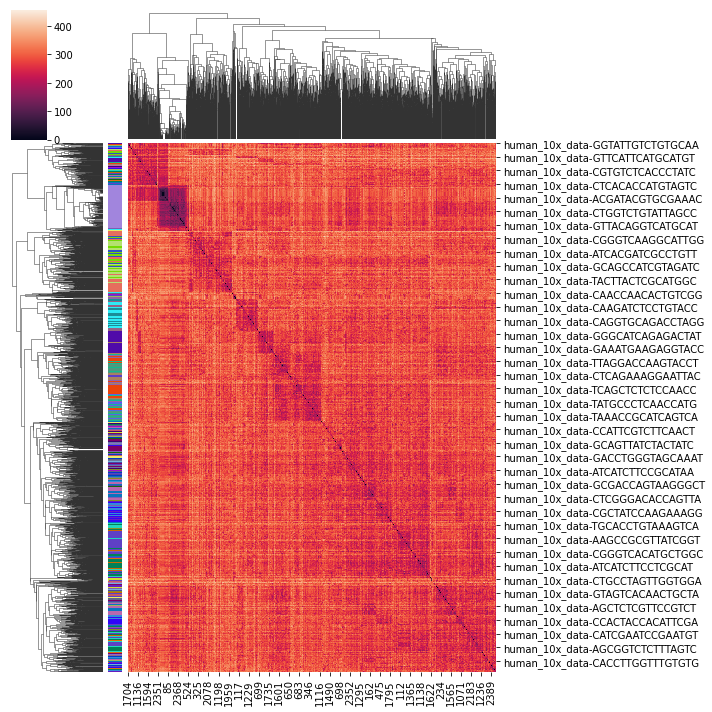

In [5]:
# linkage = tcr.stats.calculate_linkage(tcrdist_data.X, tcrdist_data.obs.index.values)
dist_plot = ftcr.plot.plot_distance_matrix(tcrdist_data, cell_id = tcrdist_data.obs.index.values, row_colors="TRA_v_gene")


Now we can calculate UMAP on the TCRDist matrix to analyze the sequences in 2D space

In [6]:
tcrdist_data.calc_umap()

... storing 'TRA_cdr3' as categorical
... storing 'TRB_cdr3' as categorical
... storing 'TRA_v_gene' as categorical
... storing 'TRB_v_gene' as categorical
... storing 'TRA_cdr3_trimmed' as categorical
... storing 'TRB_cdr3_trimmed' as categorical


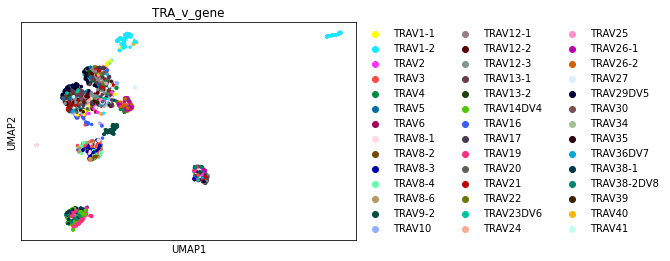

In [7]:
import scanpy as sc
sc.pl.umap(tcrdist_data, color = "TRA_v_gene")

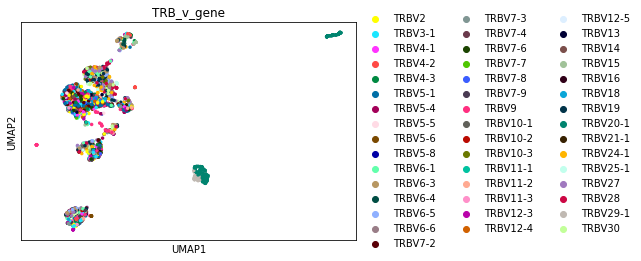

In [8]:
sc.pl.umap(tcrdist_data, color = "TRB_v_gene")

To assign our TCRs to specific clusters, we can apply hdbscan to our UMAP dimensionality reduction.  This will essentially look for communities of TCRs that are a close distance to eachother. If a TCR is seemingly not a part of a community, it will not be assigned to any cluster.  Given we don't expect every TCR to be a part of a "homology group", hdbscan is ideal for our application. The hdbscan_cluster accepts any kwargs available in the "HDBSCAN" class.

... storing 'hdbscan_clust' as categorical


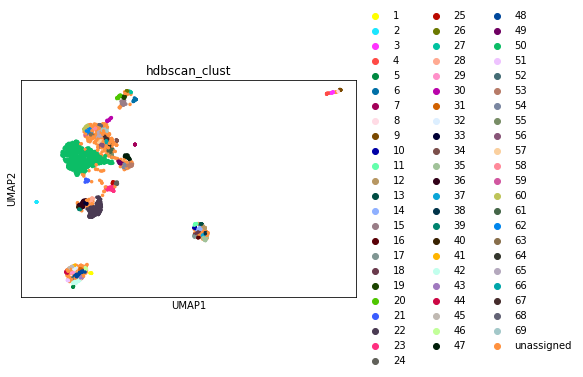

In [9]:
tcrdist_data.hdbscan_cluster()
sc.pl.umap(tcrdist_data, color = "hdbscan_clust")

In [12]:
# Look for clusters with a bunch of TRAV1-2 (MAIT cell marker)
trav12_dict = {}
clusts = set(tcrdist_data.obs["hdbscan_clust"])
for clust in clusts :
    data = tcrdist_data[tcrdist_data.obs["hdbscan_clust"] == clust]
    perc = data.obs[data.obs["TRA_v_gene"] == "TRAV1-2"].shape[0] / data.shape[0] * 100
    n_cells = len(data)
    trav12_dict[clust] = [perc, n_cells]

trav12_df = pd.DataFrame(trav12_dict, index = ["percent_TRAV1-2", "n_cells"]).T.sort_index()
trav12_df.sort_values(["percent_TRAV1-2", "n_cells"], ascending=False).head(20)

percent_TRAV1-2  n_cells
20               100.000000     28.0
19               100.000000     23.0
4                100.000000     20.0
27               100.000000     16.0
9                100.000000     15.0
3                100.000000     14.0
8                100.000000     10.0
26               100.000000      9.0
15                96.153846     26.0
6                 92.857143     14.0
30                18.181818     11.0
unassigned         5.464481    366.0
50                 0.141643    706.0
22                 0.000000    202.0
23                 0.000000     60.0
36                 0.000000     60.0
48                 0.000000     48.0
35                 0.000000     41.0
42                 0.000000     40.0
53                 0.000000     40.0

In [13]:
# Annotate cells where they have a vast majority of TRAV1-2
clusts = trav12_df.index.values[trav12_df["percent_TRAV1-2"] >= 70]
tcrdist_data.obs["possible_mait"] = [True if clust in clusts else False for clust in tcrdist_data.obs["hdbscan_clust"]]

Text(0.5, 1.0, 'TRBV usage of potential MAIT clusters')

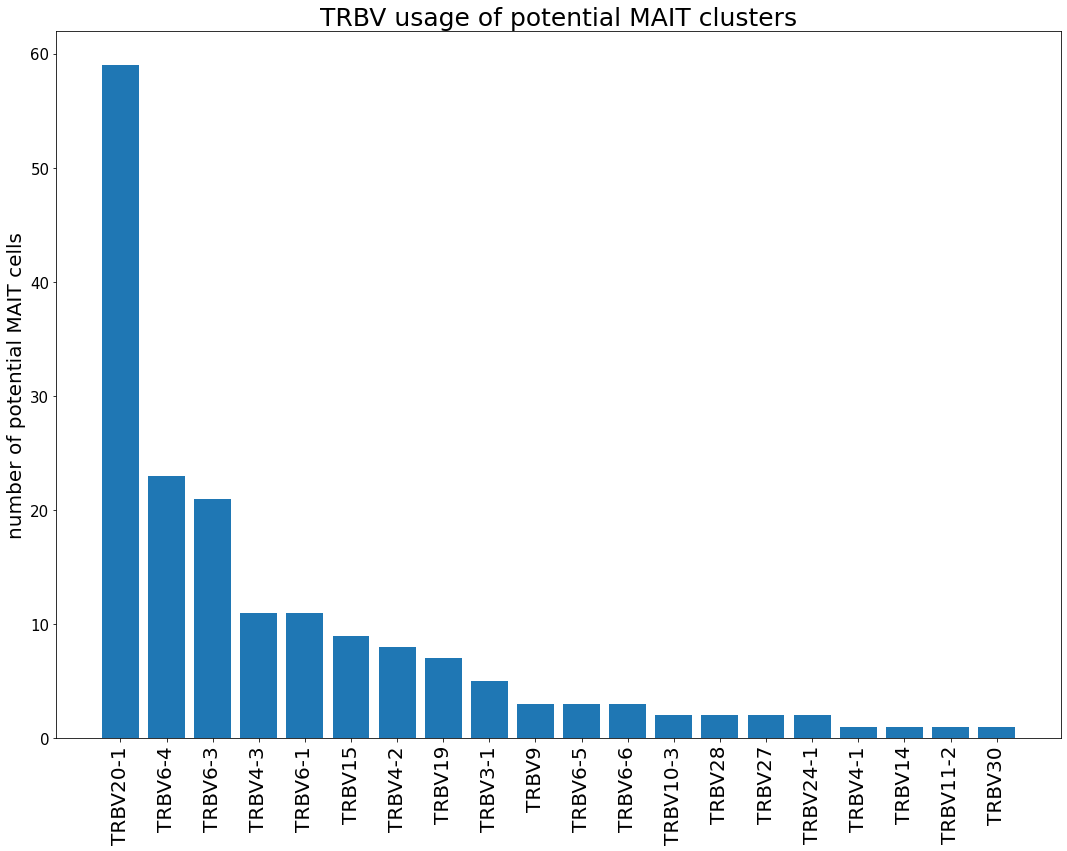

In [24]:
# Examine the diversity of the betas
beta_counter = dict(Counter(tcrdist_data.obs["TRB_v_gene"][tcrdist_data.obs["possible_mait"] == True]).most_common())
plt.figure(figsize=(18, 13))
plt.bar(x = beta_counter.keys(), height = beta_counter.values())
plt.xticks(rotation = 90, fontsize = 20)
plt.yticks(fontsize = 15)
plt.ylabel("number of potential MAIT cells", fontsize = 20)
plt.title("TRBV usage of potential MAIT clusters", fontsize = 25)

findfont: Font family ['Rosewood Std'] not found. Falling back to DejaVu Sans.


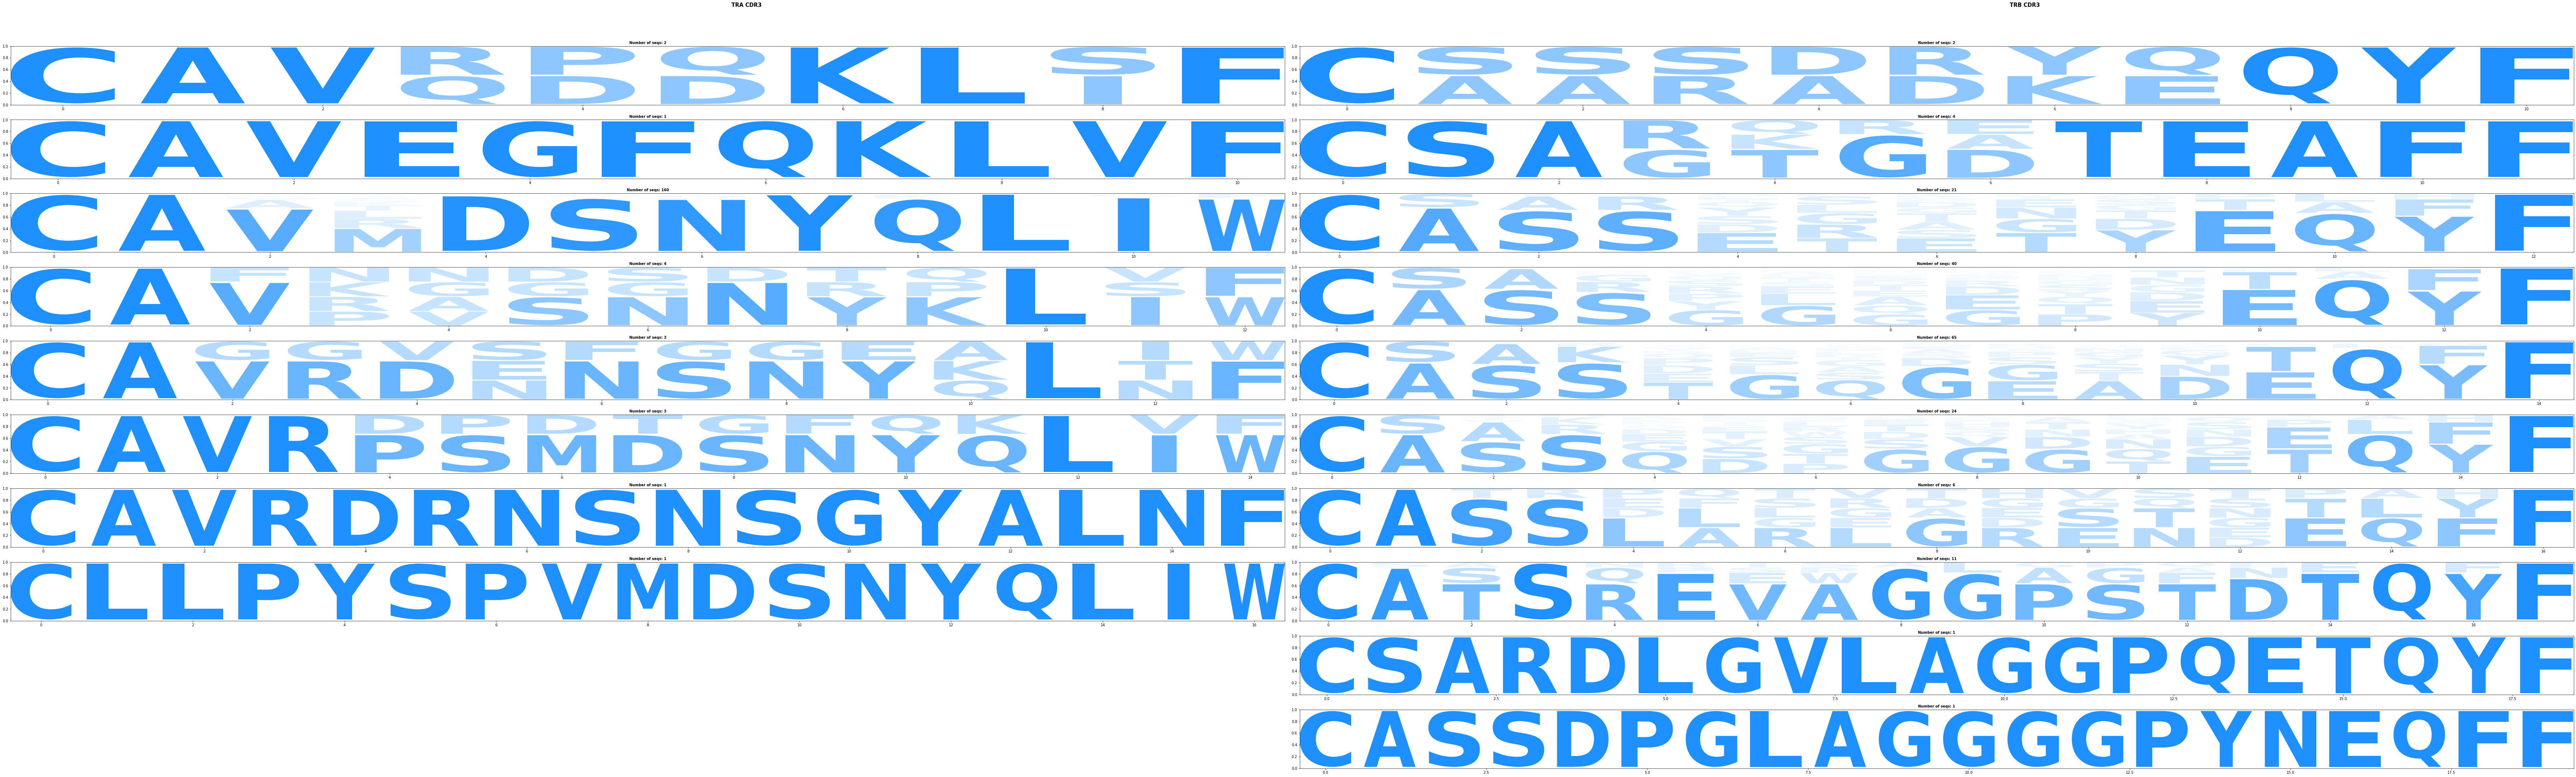

In [16]:
logo_plot = ftcr.plot.cluster_logo_plot(tcrdist_data, obs_col="possible_mait", obs_val = True, lengths = "all")